In [1]:
import os.path
import pandas as pd
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

#### _Note: See http://machine-listening.eecs.qmul.ac.uk/bird-audio-detection-challenge for more details_

# Bird Detector

## Data Load

In [2]:
meta_df = pd.read_csv("ff1010bird_metadata.csv")
print("Number of Labels: {}".format(meta_df.hasbird.size))

Number of Labels: 7690


In [10]:
SAMPLE_RATE = 44100
NORM_ENERGY = 100
N_MEL = 200
AUDIO_PATH = './wav'

def get_wav(item_id, path=AUDIO_PATH, sr=SAMPLE_RATE, eng_norm=NORM_ENERGY, **kwargs):
    """
        Get audio wav file for the given item ID
        
        :param item_id: item ID number
        :param path: path to audio files
        :param sr: sample rate of the audio signal
        :param eng_norm: normalization energy value
        
        :return: 1D numpy array
    """
    file_path = path + '/{}.wav'.format(item_id)
    wav = None
    if os.path.exists(file_path):
        wav, _ = librosa.load(file_path, sr=sr)
        if eng_norm:
            wav = wav * np.sqrt(eng_norm / np.sum(wav * wav))
    
    return wav

def get_mel_spec(item_id, **kwargs):
    """
        Get Mel spectogram for given item ID audio signal
        
        :param item_id: item ID number
        :param **kwargs: other arguments
        
        :returns: 2D numpy array
    """
    signal = get_wav(item_id, **kwargs)
    mel_spec = librosa.feature.melspectrogram(y=signal, **kwargs)
    
    return mel_spec

In [ ]:
df = meta_df.apply(lambda row: pd.Series({'item_id': int(row['itemid']), 
                                          'mel_spec': get_mel_spec(int(row['itemid']), n_mels=N_MEL), 
                                          'has_bird': row['hasbird']}), axis=1)

In [14]:
# Saving processed dataframe
df.to_pickle('mel_spec.pickle')

In [2]:
# Reading saved processed dataframe
df = pd.read_pickle('mel_spec.pickle')

## Audio and Visuals

In [3]:
ipd.Audio("wav/100.wav")

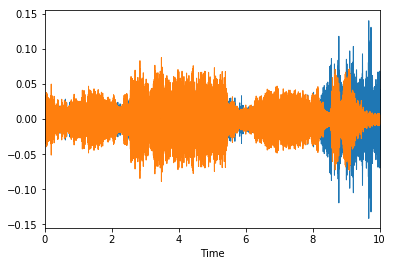

In [7]:
librosa.display.waveplot(get_wav(df[df.has_bird==1]['item_id'].iloc[0]), sr=SAMPLE_RATE)
librosa.display.waveplot(get_wav(df[df.has_bird==0]['item_id'].iloc[0]), sr=SAMPLE_RATE)

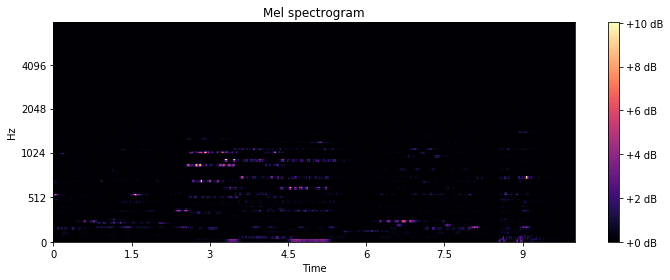

In [8]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(df[df.has_bird==0]['mel_spec'].iloc[0], sr=SAMPLE_RATE, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Mel-Model

In [76]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [6]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weights = {x: weights[x] for x in range(len(weight))}

NameError: name 'y_train' is not defined

In [12]:
# Adding channel dimension
X_train, X_test, y_train, y_test = train_test_split(pd.np.expand_dims(pd.np.array(df.mel_spec.to_list()), 
                                                                      axis=3), 
                                                    df.has_bird.to_numpy(), 
                                                    test_size=0.2)

In [97]:
x_size = X_train[0].shape[0]
y_size = X_train[0].shape[1]

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=20, 
                              input_shape=(x_size, y_size, 1), 
                              data_format="channels_last",
                              kernel_size=(10, 10),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(5, 5), 
                                    strides=(5, 5)))
model.add(keras.layers.Conv2D(filters=20, 
                              data_format="channels_last",
                              kernel_size=(10, 10),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                    strides=(2, 2)))
model.add(keras.layers.Conv2D(filters=20, 
                              data_format="channels_last",
                              kernel_size=(10, 10),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                    strides=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, 
                             activation='sigmoid',
                             kernel_initializer=keras.initializers.glorot_normal()))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 191, 853, 20)      2020      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 38, 170, 20)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 29, 161, 20)       40020     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 14, 80, 20)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 5, 71, 20)         40020     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 2, 35, 20)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1400)              0         
__________

In [98]:
batch_size=32
epochs = 5

model.fit(x=X_train, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.2,
          class_weight=weights)

Train on 4921 samples, validate on 1231 samples
Epoch 1/5
4921/4921 [==============================] - 608s 124ms/step - loss: 0.6439 - acc: 0.7301 - val_loss: 0.5975 - val_acc: 0.7547
Epoch 2/5
4921/4921 [==============================] - 610s 124ms/step - loss: 0.5948 - acc: 0.7322 - val_loss: 0.6104 - val_acc: 0.6539
Epoch 3/5
4921/4921 [==============================] - 613s 125ms/step - loss: 0.5747 - acc: 0.7393 - val_loss: 0.5921 - val_acc: 0.7644
Epoch 4/5
4921/4921 [==============================] - 608s 124ms/step - loss: 0.5468 - acc: 0.7521 - val_loss: 0.6437 - val_acc: 0.8058
Epoch 5/5
4921/4921 [==============================] - 607s 123ms/step - loss: 0.5169 - acc: 0.7757 - val_loss: 0.6387 - val_acc: 0.7262


### Model Performance

In [109]:
from sklearn.metrics import roc_curve, auc

In [104]:
y_test_pred = model.predict(x=X_test)

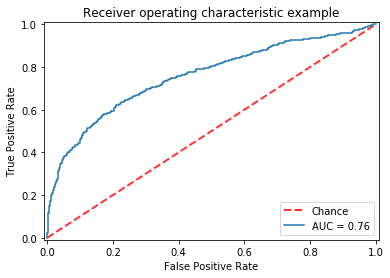

In [117]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.plot(fpr, tpr, label=r'AUC = %0.2f' % (auc(fpr, tpr)))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

# Time-Model

In [6]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [11]:
def batch_generator(data, batch_size=32, shuffle=True):
    """
        Keras batch data generator for training
        
        :param data: data from which input and target batches get created
        :param batch_size: size of the batch
        :param shuffle: flag to indicate randum shuffle during batch generation
        
        :returns: input and target batch
    """
    
    number_of_batches = int(data.shape[0]/batch_size)
    counter = 0
    sample_index = pd.np.arange(data.shape[0])
    if shuffle:
        pd.np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        # Get audio signal for each item ID
        X_batch = pd.np.array([get_wav(data.iloc[x].itemid) for x in batch_index])
        X_batch = pd.np.expand_dims(X_batch, axis=2)
        y_batch = pd.np.array([data.iloc[x].hasbird for x in batch_index])
        counter += 1
        
        yield X_batch, y_batch
        
        if (counter == number_of_batches):
            if shuffle:
                pd.np.random.shuffle(sample_index)
            counter = 0

In [12]:
data_train, data_test = train_test_split(meta_df, test_size=0.2)

In [20]:
x_size = SAMPLE_RATE * 10

model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=20, 
                              input_shape=(x_size, 1), 
                              data_format="channels_last",
                              kernel_size=10,
                              strides=1,
                              activation='tanh', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling1D(pool_size=10, 
                                    strides=10))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, 
                             activation='sigmoid',
                             kernel_initializer=keras.initializers.glorot_normal()))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 440991, 20)        220       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 44099, 20)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 881980)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 881981    
Total params: 882,201
Trainable params: 882,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size=32
epochs = 5

weights = class_weight.compute_class_weight('balanced', np.unique(data_train.hasbird), data_train.hasbird)
weights = {x: weights[x] for x in range(len(weights))}

model.fit_generator(generator=batch_generator(data_train, batch_size),
                    nb_epoch=epochs,
                    samples_per_epoch=data_train.shape[0]/batch_size,
                    validation_data=batch_generator(data_test, data_test.shape[0]).__next__(),
                    class_weight=weights)